In [ ]:
#mount this file with google drive to access files
from google.colab import drive #link this file to the google drive (use it only when you want to import file from google drive )
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Drug Review classification with Unsupervised Learning Model

**** Instructions: Step 2

*Project Topic:* Patients' opinion on the drug they are prescribing is very important because it directly influences the success of the treatment. Thus, with a **clustering unsupervised learning model**, I chose to use this Kaggle project to understand the **relationship between the opinion of the patient (compliance toward the drug) and the prescription.**

**

*Data Source:* The dataset is from kaggle; the information was gathered from web scraping of a medicine review website. In the dataset, there are 7 features and 161297 records with no specific target. 3 of the 7 columns in the dataset are in text format; thus, NLP technique, TF-IDF and word2vec, were used to successfully model building. Final model was built with Non-negative Matrix Factorization (NMF).

[The Kaggle page to the dataset](https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018/data).

** Instructions: Step 1

*Identifying the unsupervised Leraning Problem:* The dataset included the rating, drug name that patient uses, condition the patient had, review from patient regarding their precription. I attempted **to predict the rating and the condition of the patient have with the rest of the information in the dataset in this project.** Since it is a Kaggle dataset, I reference the following journal article during my model building:

*Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125.*

[EDA Section](#cell-id)

In [ ]:
import numpy as np
import pandas as pd

import re
import itertools
import nltk
import math
nltk.download('stopwords')
from nltk.corpus import stopwords
# from nltk.tokenize import (TweetTokenizer, wordpunct_tokenize,)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_colwidth = 500

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/ML_DL_projects/drug_unsupervised/drug_kaggle_dataset/drugsComTrain_raw.csv')

<a name="cell-id"></a>
# Instruction Step 3 : Exploratory Data Analysis (EDA)

*   Step 1: Basic feature exploration

    * Top 20 condition by count
    * The top 20 drugs with the 10/10 rating
    * Top 20 drugs with the 1/10 rating
*   Step 2: NLP data transform (remove stopword)
    
    Since the review is in text format, which needed to be feature engineered into numerical format. I use NLP techiques to clean up the text to reduce noises, such as html, numbers, punctuations, extra space, spelling mistakes, and lemmization.
    
    *Special note:* since sentimentl analysis is one of my target, I did not remove the stopwords. The stopwords can be representation on the positive or negetive aspects of the review.
*   Step 3: [Feature Engineering](#cell-id2) - Textblob sentiment, TF-IDF, word2vec, one-hot encoder+PCA
*   Step 4: Rating & condition pro_rated

    I planned to use Metrix Factorization as model. However, it can not handle too many categories, so, I pro_rated the user ratings into 3 categories: positive, negetive, and neutral. The condition is picked for the top 5 high in frequency.
*   Step 5: missing value

    There are some missing value in the review and category columns. To make the dataset consistant with all value with meaning, I remove these rows.
*   Step 6: [Correlation](#cell-id3)

    I want to make sure there are some correlation between the sentiment and the user rating since one of my goal is to predict the user rating from the reviews. From this following plot, there is a positive corrlation between the sentiment and the user rating.

    *Special note:* Since the corrlation is not strong between the sentiment and the rating, it is a warning sign that the prediction power maybe very weak. Thus, I also looked at the correlation heapmap based on the prediction of the condition. The result is very premission.




In [ ]:
#Basic Feature exploration:
print("Total number of records & features: ",df.shape)
print("Column Names: ",df.columns)
print("Unique rating:", df['rating'].nunique())
print("Unique drugName:",df['drugName'].nunique())
print("Unique condition:",df['condition'].nunique())

Total number of records & features:  (161297, 7)
Column Names:  Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')
Unique rating: 10
Unique drugName: 3436
Unique condition: 884


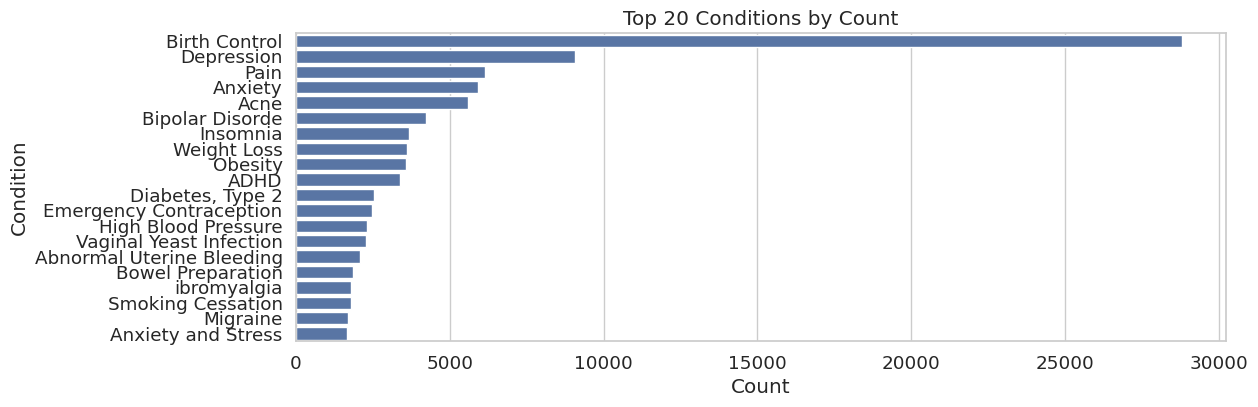

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(data=df, y='condition', order=df['condition'].value_counts().index[:20])
plt.title('Top 20 Conditions by Count')
plt.xlabel('Count')
plt.ylabel('Condition')
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

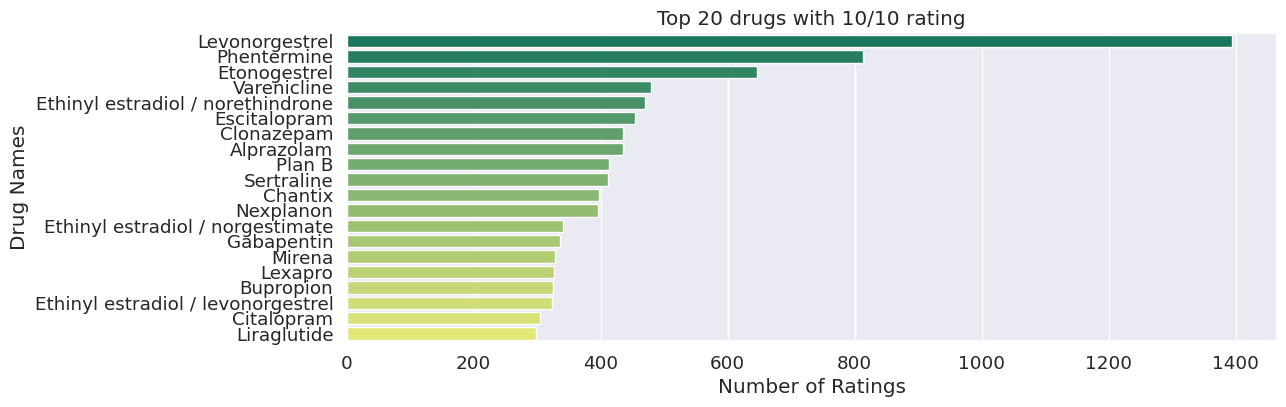

In [ ]:
# This barplot shows the top 20 drugs with the 10/10 rating

sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [12, 4]
rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())
sns_rating = sns.barplot(x = drug_rating[0:20], y =drugname[0:20] , palette = 'summer')
sns_rating.set(title = 'Top 20 drugs with 10/10 rating', ylabel ="Drug Names" , xlabel = 'Number of Ratings')
plt.setp(sns_rating.get_xticklabels());

<ipython-input-41-4d2ae0242e99>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns_rating = sns.barplot(x =drug_rating[0:20] , y = drugname[0:20], palette = 'winter')


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

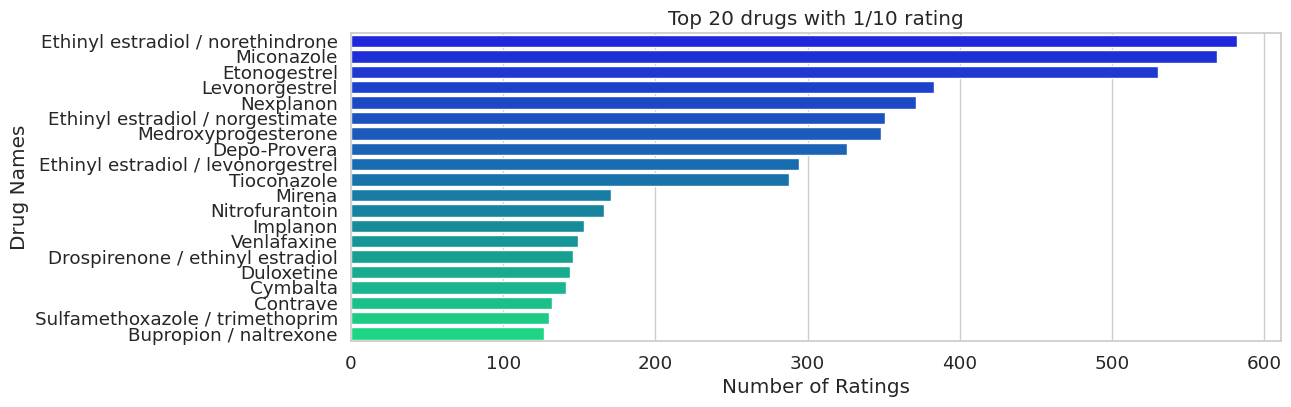

In [ ]:
# This barplot shows the Top 20 drugs with the 1/10 rating

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [12, 4]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x =drug_rating[0:20] , y = drugname[0:20], palette = 'winter')

sns_rating.set(title = 'Top 20 drugs with 1/10 rating', ylabel = "Drug Names", xlabel = 'Number of Ratings')

plt.setp(sns_rating.get_xticklabels());



[EDA Section](#cell-id)

**EDA Step2: Text Noises Reduction**
    
Since the review is in text format, which needed to be feature engineered into numerical format. I use NLP techiques to clean up the text to reduce noises, such as html, numbers, punctuations, extra space, spelling mistakes, and lemmization.

In [ ]:
!pip install beautifulsoup4
!pip install contractions
!pip install Unidecode
!pip install pyspellchecker
!pip install tqdm

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
# Define a function to correct spelling using spaCy
def correct_spelling(text):
    doc = nlp(text)
    corrected_text = " ".join([token.text for token in doc])
    return corrected_text

In [ ]:
#Text Noises Reduction
import contractions
from bs4 import BeautifulSoup
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
  #nlp reference:https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8

review = df[['review']].copy()
review['uniqueID'] = df['uniqueID']
  ##lower case
review['lower'] = review['review'].apply(lambda x: x.lower())
  ##expand contraction
review['contraction'] = review['lower'].apply(
    lambda x: " ".join([contractions.fix(expanded_word) for expanded_word in x.split()]))
  ## remove html tags
review['html'] = review['contraction'].apply(
    lambda x: BeautifulSoup(x, 'html.parser').get_text())
  ##remove numbers
review['num_off'] = review['html'].apply(lambda x: re.sub(r'\d+', '', x))
  ##remove punctuations
review['punchtuation']  = review['num_off'] .apply(
    lambda row: re.sub(r'[^\w\s]+', '', row))
  ## Take off the extra space
review['space_off'] = review['punchtuation'].apply(
    lambda x: re.sub(' +', ' ', x))
  ##spelling mistakes
tqdm.pandas()
review['spell'] = review['space_off'].progress_apply(correct_spelling)
    #review['spell'] = review['space_off'].apply(lambda x: str(TextBlob(x).correct()))
    #review['spell'] = review['space_off'].progress_apply(lambda x: str(TextBlob(x).correct()))
    # stopwords - not use because it is senitment analysis
    # stop_words = stopwords.words('english')
    # text_col = text_col.apply(
    #     lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
  ##lemmatizer the sentance
lemmatizer = WordNetLemmatizer()
review['clean'] = review['spell'].apply(lambda x: lemmatizer.lemmatize(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-15-28047922c647>:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda x: BeautifulSoup(x, 'html.parser').get_text())
100%|██████████| 161297/161297 [58:13<00:00, 46.17it/s]


In [ ]:
#review[['uniqueID','review','clean']].to_csv('/content/gdrive/MyDrive/ML_DL_projects/drug_unsupervised/drug_kaggle_dataset/clean_review.csv')
review = pd.read_csv('/content/gdrive/MyDrive/ML_DL_projects/drug_unsupervised/drug_kaggle_dataset/clean_review.csv')

<a name="cell-id2"></a>
**Step3: Feature Engineering - Text transformation**
*   ***Sentiment Analysis***

    The Textblob has a package to categorize the text into either postive, negetive, or neutral.
*   ***TF-IDF***

    This is the techique that consider the frequency of the word in a docutment and the corpus, which represents the uniqueness and frequency of a particular word in the text.
*   ***One-hot Encoder + PCA***

    I felt that there maybe relationship between condition or drug because they are in the similar category. I want to make sure that relationship is captured. I decided to one-hot encode all the drug and condition. Then, PCA the two columns to reduce the information and drawn out the information.
*   ***Word2vec***

    This is neuro-network training to find out the relationship between the words and represented it with vectors.



Since I am not sure which numerical representation is better for the model. I did all three methods for further model building.

[EDA Section](#cell-id)

In [ ]:
#Substep2: Feature Engineering - Text transformation
# sentiment analysis with textblob
from textblob import TextBlob
from tqdm import tqdm
tqdm.pandas()
df['sentiment'] = df['review'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)

100%|██████████| 161297/161297 [01:54<00:00, 1407.23it/s]


In [ ]:
#Substep2: TF-IDF Feature Engineering - Text transformation
vector = TfidfVectorizer(max_df = 0.90, min_df = 2, stop_words = 'english')
vector_train = vector.fit_transform(review['clean'])
print(vector_train.shape)
print(vector_train.count_nonzero())

In [ ]:
# Substep2: Feature Engineering with One-hot encoder+PCA the 'drugName','condition' column
one_hot_encoded = pd.get_dummies(df['condition'], prefix='Category')
one_hot_encoded.shape

(161297, 884)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features (optional but recommended for PCA)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(one_hot_encoded)

# Apply PCA with 2 components (you can choose a different number)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a new DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Print the result
print(df_pca[:2])

        PC1       PC2
0 -3.732808 -1.500508
1 -0.505153  0.126962


In [ ]:
one_hot_drug = pd.get_dummies(df['drugName'], prefix='Category')
# Standardize the features (optional but recommended for PCA)
scaler = StandardScaler()
scaled_features_drug = scaler.fit_transform(one_hot_drug)

# Apply PCA with 2 components (you can choose a different number)
pca_drug = PCA(n_components=2)
principal_components_drug = pca_drug.fit_transform(scaled_features_drug)

# Create a new DataFrame with the principal components
df_pca_drug = pd.DataFrame(data=principal_components_drug, columns=['PCD1', 'PCD2'])

# Print the result
print(df_pca_drug[:2])

       PCD1      PCD2
0  0.116054  0.235765
1 -1.039219 -0.204306


In [ ]:
#save the modify dataset for future use
#combine dataset - df, review, df_pca, df_pca_drug
#df_model = pd.concat([df,df['sentiment'],review,df_pca, df_pca_drug], axis=1)
#df_model.to_csv('/content/gdrive/MyDrive/ML_DL_projects/drug_unsupervised/drug_kaggle_dataset/clean_review.csv')
df_model = pd.read_csv('/content/gdrive/MyDrive/ML_DL_projects/drug_unsupervised/drug_kaggle_dataset/clean_review.csv')

In [ ]:
# Substep2: Feature Engineering with word2vec
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# Tokenize sentences into words
df_model['tokens'] = df_model['clean'].apply(word_tokenize)

# Train a Word2Vec model
model = Word2Vec(df_model['tokens'], vector_size=100, window=5, min_count=100, sg=1)

# Calculate sentence vectors
def get_sentence_vector(tokens):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return sum(vectors) / len(vectors) if vectors else None

# Get sentence vectors
sentence_vectors = df_model["tokens"].apply(get_sentence_vector)

# Convert sentence vectors to a sparse matrix
sparse_matrix = csr_matrix(sentence_vectors.tolist())

# Print the sparse matrix
print(sparse_matrix)

**EDA Step 4: Rating & condition pro_rated**

I planned to use Metrix Factorization as model. However, it can not handle too many categories, so, I pro_rated the user ratings into 3 categories: positive, negetive, and neutral. The condition is picked for the top 5 high in frequency.

In [ ]:
def squashRating(x):
  return math.floor((x-1)/3.1)

In [ ]:
df_model['pro_rate'] = df_model['rating'].apply(squashRating)
df_model['pro_rate'].value_counts()

pro_rate
2    97410
0    40075
1    23812
Name: count, dtype: int64

In [ ]:
removed_rows = df_model.query('pro_rate == 2').sample(frac=0.6).index
df_model = df_model.drop(removed_rows)
df_model['pro_rate'].value_counts()

pro_rate
0    40075
2    38964
1    23812
Name: count, dtype: int64

**EDA Step 5: Missing value**

There are some missing value in the condition, the rows will be removed for consistancy.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [ ]:
#missing value of review
print(df_model['clean'].isna().sum())
df_model['clean'] = df_model['clean'].fillna('')

In [ ]:
df_model['condition'] = df_model['condition'].fillna('')
removed_rows = df_model.query('condition.str.contains("Birth Control")').sample(frac=0.7).index
df_model = df_model.drop(removed_rows)

condition
Birth Control                28788
Depression                    9069
Pain                          6145
Anxiety                       5904
Acne                          5588
Bipolar Disorde               4224
Insomnia                      3673
Weight Loss                   3609
Obesity                       3568
ADHD                          3383
Diabetes, Type 2              2554
Emergency Contraception       2463
High Blood Pressure           2321
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2096
Bowel Preparation             1859
ibromyalgia                   1791
Smoking Cessation             1780
Migraine                      1694
Anxiety and Stress            1663
Name: count, dtype: int64


<a name="cell-id3"></a>
**EDA Step6: correlation**

I want to make sure there are some correlation between the sentiment and the user rating since one of my goal is to predict the user rating from the reviews. From this following plot, there is a positive corrlation between the sentiment and the user rating. Since the corrlation is not strong between the sentiment and the rating, it is a warning sign that the prediction power maybe very weak.

Thus, I also looked at the correlation heapmap based on the prediction of the condition. The result is very premission.

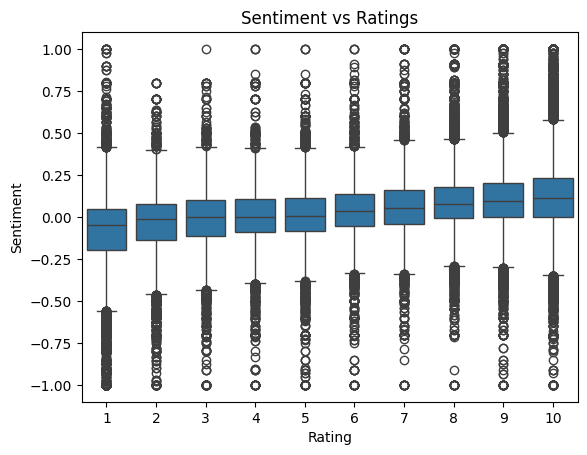

In [ ]:
sns.boxplot(x=np.array(df_model["rating"]),y=np.array(df_model["sentiment"]))
plt.xlabel("Rating")
plt.ylabel("Sentiment")
plt.title("Sentiment vs Ratings")
plt.show()

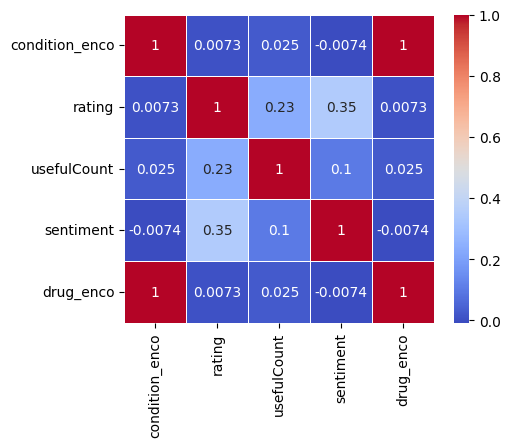

In [ ]:
#correlation heatmap for condition based prediction
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_model['condition_enco'] = le.fit_transform(df_model['drugName'])
df_model['drug_enco'] = le.fit_transform(df_model['drugName'])

correlation_matrix = df_model[['condition_enco','rating','usefulCount', 'sentiment', 'drug_enco']].corr()
# Plot the heatmap and add annotations
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

# Instructions Step 4: model Building & Behind

**Target result 1: predict user rating**

In this section, I attempted the model building few different dataset with specific reason with simple clustering model.

**Model #1 kmean (unsupervised)*

Since it is a clustering question, k means is a suitable model. However, due to the nature of the kmean, which will repeatly finding the centroid, the dataset is too large for it to be able to run. I have to reduce the dataset to 10,000, thus, the accuracy is also an issue.

**Model #2 Agglomerative Clustering (unsupervised)*

With the same reasoning of a clustering prediction, Agglomerative Clustering is a suitable model. I again have to reduce the dataset to 10,000, thus, since the model was also not able to process such large dataset and also with poor prediction.

At this point of time, I realized that it is maybe an issue to have 10 clustering. So, I pro_rated the user review into 3 categories only: the postive, neutral, and negetive. As the accuracy table shown, the result is getting better, but not good enough.

In addition, there maybe too much noises in the dataset since the bottom 20 condition and drug has very little reviews. So, I picked the top 30 frequent condition to predict only. The prediction is still not close to ideal.

A different model & appoarch is needed.

Type of model                 |Accuracy
------------------------------|---------
k mean with textblob sentiment|0.23
Agglomeerative Clustering with textblob sentiment and pro_rate review|0.31
k mean with textblob sentiment and pro_rate review|0.45
Agglomeerative Clustering with textblob sentiment and pro_rate review|0.56
k mean with textblob sentiment and pro_rate review with top 30 drugs only|0.42


[NMF Model Building](#cell-id4)




In [ ]:
#kmean & agglomerativeclustering model on user rating
lower = 20000
from sklearn.cluster import AgglomerativeClustering, KMeans
print(df_model.shape)
model_1 = AgglomerativeClustering(n_clusters = 3).fit(df_model[lower:lower+1000])
model_2 = kmean(n_clusters = 3).fit(df_model[lower:lower+1000])

In [ ]:
#Visualizing the clustering
import math
def squashRating(x):
  return math.floor((x-1)/5)
df['mappedRating'] = df['rating'].apply(squashRating)
colour = df['mappedRating'][lower:lower+1000].to_numpy()
print(colour)
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(df_model['sentiment'][lower:lower+1000], df_model['sentiment'][lower:lower+1000],
           c = model.fit_predict(df_model[lower:lower+1000]), cmap ='Paired')
axs[1].scatter(df_model['sentiment'][lower:lower+1000], df_model['sentiment'][lower:lower+1000],
           c = colour, cmap ='Paired')
plt.show()

In [ ]:
#Check accuracy
perms = list(itertools.permutations(list(range(3))))
acc=[]
yp = model_1.fit_predict(df_model[lower:lower+1000])
for i in range(len(perms)):
    mapdict = dict(zip(list(range(2)),list(perms[i])))
    yt = df['mappedRating'][lower:lower+1000].replace(mapdict)
    acc.append(accuracy_score(yt,yp))
print(max(acc))

0.56


In [ ]:
## Select the top 30 condition + top 50 drug
condition_30 = df_model["condition"].value_counts().index[:30].tolist()
condition_30_df = df_model[df_model["condition"].isin(condition_30)]
print(condition_30_df.shape)

(55323, 28)


In [ ]:
## Select the top 50 drug
drug_50 = condition_30_df["drugName"].value_counts().index[:50].tolist()
drug_50_df = condition_30_df[condition_30_df["drugName"].isin(drug_50)]
print(drug_50_df.shape)

(22677, 28)


In [ ]:
#kmean model with chop database (top 50 drug)
from sklearn.cluster import AgglomerativeClustering, KMeans
model = AgglomerativeClustering(n_clusters = 3).fit(drug_50_df[['usefulCount','sentiment','PC1', 'PC2', 'PCD1', 'PCD2']])

In [ ]:
#Check accuracy
perms = list(itertools.permutations(list(range(2))))
drug_50_df['pro_rate']=drug_50_df['rating'].apply(squashRating)

removed_rows = drug_50_df.query('pro_rate != 1').sample(frac=0.3).index
print(drug_50_df['pro_rate'].value_counts())
drug_50_df = drug_50_df.drop(removed_rows)
print(drug_50_df['pro_rate'].value_counts())
acc=[]
yp = model.fit_predict(drug_50_df[['usefulCount','sentiment','PC1', 'PC2', 'PCD1', 'PCD2']])
for i in range(len(perms)):
    mapdict = dict(zip(list(range(2)),list(perms[i])))
    # print(mapdict)
    yt = drug_50_df['pro_rate'].replace(mapdict)
    # yt = yt['mappedRating']
    # print(yt.shape)
    # print(yp.shape)
    acc.append(accuracy_score(yt,yp))

print(max(acc))

pro_rate
0    6244
2    5958
1    5245
Name: count, dtype: int64
pro_rate
1    5245
0    4362
2    4179
Name: count, dtype: int64
0.41926592194980417


<a name="cell-id4"></a>
**Target result 1: predict user rating**

**Model #3 Matrix Factorization(unsupervised)*

Since the other two models can not handle the large dataset, third model matrix factorization is used. I have tried a few different dataset and pre-processing for the model. The results are improved in comparison with the simple clustering model. However, the result was still not ideal and all trial has accuracy until 0.55.

**

Trial 1: I started with NMF model with pro_rate user, TF-IDF on user review, and PCA on one-hot encoding the condition and drug.

Trial 2: NMF model with pro_rate user, one hot on the drug and condition, TF-IDF on user review

Trial 3: word2Vec on user review, and PCA on one-hot encoding the condition and drug

Trial 4: word2Vec on user review, and one-hot encoding the condition and drug

Trial 5: dot product to combine word2vec and TF-IDF on user review, and PCA on one-hot encoding the condition and drug

Trial 6: dot product to combine word2vec and TF-IDF on user review, and one-hot encoding the condition and drug

Trial 7: use only top 20 conditions of the dataset with trial 6 model

Trial 8: elimitated birth control as condition with trial 6 model

Trial 9: increase weight on the drug and condition with trial 6 model

Trial 10: increase weight on the useful count with trial 6 model


Type of model                 |Accuracy
------------------------------|---------
one-hot/PCA on drug/condition + TF-IDF on review|0.38
one-hot on drug/condition + TF-IDF on review/condition|0.35
one-hot/PCA on drug/condition + word2vec on review|0.39
one-hot on drug/condition + word2vec on review/condition|0.42
one-hot/PCA on drug/condition + combo on review|0.45
one-hot on drug/condition + combo on review/condition|0.53
elimitated birth control|0.37
Increase weight on the drug & condition|0.43
Increase weight on the useful count|0.55

[Prediction with patient condition](#cell-id5)


In [ ]:
#Trial example
#and PCA on one-hot encoding the condition and drug.
#Step 1: Creating predict function
def predict(matrix):
    sorted_matrix = np.argsort(matrix)
    n_predictions, maxValue = sorted_matrix.shape
    predictions = [[sorted_matrix[i][maxValue - 1]] for i in range(n_predictions)]
    category = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        category[i] = predictions[i][0]
    return category

In [ ]:
# Step 2: Creating label_permutation function + calculate the accuracy
def label_permutation(df,y_pred,n=3):
    perms = list(itertools.permutations([0,1,2]))    #create permutation list
    best_labels, best_acc, current = [], 0, {}

    labels = [0,1,2]
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 3:
                conditions = [
                    (df['pro_rate'] == current[0]),
                    (df['pro_rate'] == current[1]),
                    (df['pro_rate'] == current[2]),]

                df['test'] = df['pro_rate'].map(current)
                current_accuracy = accuracy_score(df['pro_rate'], y_pred)
                print(current_accuracy)
                if current_accuracy > best_acc:
                    best_acc = current_accuracy
                    best_labels = perm
                    df['best'] = df['test']
    return best_labels, best_acc

In [ ]:
from sklearn.decomposition import NMF
n_components = 3
# Step 3: Creating NMF model and fitting in data for the first try
nmf = NMF(n_components = n_components)
#full_vector = vector_train.toarray().hstack(df['drugName'].to_numpy())

nmf.fit(vector_train)
y_train = predict(nmf.transform(vector_train))
best_labels, best_acc = label_permutation(df_model, y_train)
print('Model training Accuracy: ', best_acc)

perms = list(itertools.permutations(list(range(n_components))))

acc=[]
yp = y_train
for i in range(len(perms)):
    mapdict = dict(zip(list(range(n_components)),list(perms[i])))
    # print(mapdict)
    yt = df_model['pro_rate'].replace(mapdict)
    # yt = yt['mappedRating']
    # print(yt.shape)
    # print(yp.shape)
    acc.append(accuracy_score(yt,yp))

print(acc)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
0.3788721588184521
Model training Accuracy:  0.3788721588184521
[0.3788721588184521, 0.38093411335954735, 0.31941114414500815, 0.3337968735014865, 0.2873309676800614, 0.2996547424954445]


In [ ]:
# Trial example with one-hot encoding on the condition and drug only + enhance the importance of drug and condition
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack

print(df_model['clean'].isna().sum()) #
df_model['clean'] = df_model['clean'].fillna('')#
# Instantiate the OneHotEncoder
onehotencoder = OneHotEncoder()

# Transform the categorical columns
transformed_data = onehotencoder.fit_transform(df_model[['drugName','condition']])
sparse_transform = csr_matrix(transformed_data)
df_model['Date'] = pd.to_datetime(df_model['date'], format='%d-%b-%y')

# Extract year, month, and day
df_model["year"] = df_model["Date"].dt.year
df_model["month"] = df_model["Date"].dt.month
df_model["day"] = df_model["Date"].dt.day

df_model = df_model[df_model['condition'].str.contains("Birth Control")]
print(df_model)
# Combine components into an integer representation
df_model["integer_date"] = ((df_model["year"]-2000) * 1000 + df_model["month"] * 100 + df_model["day"])/10000.0
print(df_model['integer_date'])
date_matrix = csr_matrix(df_model['integer_date']).transpose()
print(date_matrix)
# df_model['condition'] = df_model['condition'].fillna('')
df_model['combined'] = (df_model['condition'] + ' ')*0 +(df_model['drugName']+' ')*10+(df_model['clean']+' ')*1
print(df_model['combined'])

<a name="cell-id5"></a>
**Target result 2: predict user condition**

With all the painful experiment, it is very difficult to enhanced the correlation information via unsupervised learning to predict rating. I have now move on to the second target result: predict top 5 user condition with information on presciption and reviews.

Since the birth control dominate the dataset, I decided to remove it to balance the dataset. For the model building, I have used the NMF model, TF-IDF to vectorize the user review nd drug name. The performance of the model toward the target is satifying. Thus, I also tried few effort to tune the hyperparameter in hope to gain better accuracy.

Hyperparameter Tuning Table:

solver|beta_loss|Accuracy
----------------------------|-|---------
Default|Default|0.66
mu|Default|0.84
mu|kullback-leibler|0.856


In [ ]:
from sklearn.preprocessing import OneHotEncoder
df_model = pd.read_csv('/content/gdrive/MyDrive/ML_DL_projects/drug_unsupervised/drug_kaggle_dataset/clean_review.csv')
# Create an instance of OneHotEncoder
encoder = OneHotEncoder()
drug_df = df_model[df_model['condition'].isin(df_model['condition'].value_counts()[:5].index)]
drug_df['clean'] = drug_df['clean'].fillna('')
drug_df['drugName'] = drug_df['drugName'].fillna('')
#print(drug_df['drugName'].value_counts()[:10])
removed_rows = drug_df.query("condition.str.contains('Birth Control')").sample(frac=0.7).index
drug_df = drug_df.drop(removed_rows)
#print(drug_df['condition'].value_counts()[:])
# encoded_drug_df = encoder.fit_transform([drug_df['condition']])

In [ ]:
drug_df['combined'] = (drug_df['drugName'] + ' ')*1 +(drug_df['clean']+' ')*1
#print(drug_df['combined'])
vector = TfidfVectorizer(max_df = 0.90, min_df = 2, stop_words = 'english')
vector_train = vector.fit_transform(drug_df['combined'])

In [ ]:
def predict(matrix):
    sorted_matrix = np.argsort(matrix)
    n_predictions, maxValue = sorted_matrix.shape
    predictions = [[sorted_matrix[i][maxValue - 1]] for i in range(n_predictions)]
    category = np.empty(n_predictions, dtype = np.int64)
    for i in range(n_predictions):
        category[i] = predictions[i][0]
    return category

In [ ]:
from sklearn.decomposition import NMF
n_components = 5
# Step 3: Creating NMF model and fitting in data for the first try
nmf = NMF(n_components = n_components,solver='mu',beta_loss = 'kullback-leibler')
#full_vector = vector_train.toarray().hstack(df['drugName'].to_numpy())

nmf.fit(vector_train)
y_train = predict(nmf.transform(vector_train))
# best_labels, best_acc = label_permutation(drug_df, y_train)
# print('Model training Accuracy: ', best_acc)

perms = list(itertools.permutations(list(range(n_components))))
drugs = drug_df['condition'].unique()
acc=[0]*len(perms)
yp = y_train
for i in range(len(perms)):
    mapdict = dict(zip(drugs,list(perms[i])))
    #print(mapdict)
    yt = drug_df['condition'].replace(mapdict)
    # yt = yt['mappedRating']
    # print(yt.shape)
    # print(yp.shape)
    acc[i] = (accuracy_score(yt,yp))
    if (i/100) - math.floor(i/100) == 0: print(i)

print(max(acc))

0
100
0.857563239205478


# Conclusion

In this dataset, the correlation between data and the rating is fairly weak. According to other notebook, it is a possibility to have a satified prediction result with supervised learning model. However, with unsupervised ones, the importance of the review length, and usefulness count can not be enhance enough to make a satified result. There is no good comination of tuning the dataset, NLP techique, or model that can help with the situation.


However, on the other hand, the prediction on the condition based on other information in the dataset can work. The NMF model with word frequency based NLP tool, TF-IDF can produce successful result. The only downside is that due to the nature of the matrix factorization, there is only few categories that be in the prediction at the same. Neuro-network model maybe better suited for this dataset in general.